In [6]:
#run this once to set up - then run next cell for each member
# replace encoded1.csv with file paul scraped
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# function for ratings scrape

def user_ratings(username):
    ratings_count = 0
    user_ratings = []
    avail_results = True 
    while avail_results:
        # assemble the url, make the request, isolate table
        url = f"https://www.beeradvocate.com/user/beers/?start={ratings_count}&ba={username}&order=dateD&view=R"
        html = requests.get(url)
        print(html.url)
        soup = BeautifulSoup(html.text, 'html.parser')
         # number of user ratings 
        ######need to dump the ratings from user scrape
        
        results = soup.find_all('table')
        

        #increase ratings count to get next page
        ratings_count += 50
        
        #get correct table rows
        ratings_list = results[0].find_all('tr')[3:] #increase ratings count to get next page
        
        #####need catch for no user ratings
        if len(ratings_list) > 0:
        
            #loop through and sort info
            for tr in ratings_list:
                tds = tr.find_all('td')

                # isolate some info
                user_rating = tds[-2].text
#                 abv = tds[-3].text
                rDev = re.findall(r"([\d.]*\d+)", tds[-1].text)[0]
                # further isolate element in list holding 3 features
                add_beer_info = tds[2].find_all('a')
                
                # extract info
#                 beer_name = add_beer_info[0].text
                beer_link_total = add_beer_info[0]['href']
                base_url_ba = "https://www.beeradvocate.com"
                beer_link = base_url_ba + beer_link_total[0:beer_link_total.find("?")]
#                 beer_style = add_beer_info[2].text
#                 brewery = add_beer_info[1].text

                #dump into dict
                ratings_dict = {
#                     "beer_name": beer_name,
#                     "brewery": brewery,
#                     "beer_style": beer_style,
#                     "beer_style_match": re.sub(r'\W+', '', beer_style.lower()),
                    "beer_link": beer_link,
                    "user_rating": user_rating,
#                     "abv": abv,
                    "rDev": rDev

                }

                # append link to list
                user_ratings.append(ratings_dict)
        else: 
            
            avail_results = False
    user_ratings_df = pd.DataFrame(user_ratings).drop_duplicates()
    
    return user_ratings_df

def match_styles(username):
    #create df of user ratings
    user_ratings_df = user_ratings(username)
    print(len(user_ratings_df))

# kxa moved this to current folder
    beer_features_df = pd.read_csv("../encoded1.csv")
    user_ratings_df = user_ratings_df.merge(beer_features_df, left_on = 'beer_link', right_on = 'URL', how = "right")
    rec_df = user_ratings_df[user_ratings_df['beer_link'].isnull()]
    user_df = user_ratings_df[user_ratings_df['beer_link'].notnull()]
    return rec_df, user_df

In [7]:
member = 'brutaltruth'
rec_df, user_df = match_styles(member)
print("length user_df",len(user_df))
print("length rec_df", len(rec_df))

# convert rating to numeric
user_df['user_rating'] = pd.to_numeric(user_df['user_rating'])

# bins - not currently used - but may want to explore
# user_df.info()
# user_df[user_df['user_rating']>3.5]
bins = [1,2,3,4,5.1]
labels = ['1-1.99', '2-2.99','3-3.99','4-5']
user_df['bin'] = pd.cut(user_df['user_rating'],bins=bins, labels=labels)

user_df['bin'].value_counts()


# determine what is good and what is bad
fourAndAbove = user_df['beer_link'][user_df['bin']=='4-5'].count()
print("fourAndAbove Count",fourAndAbove)

# this is how many records = 5% of the count of ratings
fivePercentCount = int(len(user_df) * .05)
print("fivePercentCount",fivePercentCount)

# need to do a check here - if fiverPercentCount is less than ? then we need to do something else

#sort by user_rating descending and then reindex
user_sort = user_df.sort_values(by='user_rating', ascending = False)
user_sort = user_sort.reset_index(drop=True)

#get the rating score at the 5 percent mark
fivePercentRating = user_sort['user_rating'].iloc[fivePercentCount-1] # zero based so subtract 1 

#one line approach to set good/bad to set goodbad
user_sort['goodtest'] = np.where(user_sort['user_rating']>=fivePercentRating, 'good','bad')

# # prefer the one line approach to assigning good/bod - but this might be easier to read if we do something more complicated
# def goodBad(row):
#     if row['user_rating'] >= fivePercentRating:
#         val = 'good'
#     else:
#         val = 'bad'
#     return val

# # apply good or bad - uses goodBad function
# user_sort['good'] = user_sort.apply(goodBad, axis=1)

# csvs are going to same folder
user_sort.to_csv(member+'sortmatch.csv', index = False)

# print("this should be bad", user_sort.iloc[fivePercentCount+10]) #if there are 10 beers with same rating this could come out good!
# print("this should be good", user_sort.iloc[fivePercentCount-1])      

# user_df.columns

# user_df.to_csv(member+'match.csv', index = False)

rec_df.to_csv(member+'recs.csv', index = False)

https://www.beeradvocate.com/user/beers/?start=0&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=50&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=100&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=150&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=200&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=250&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=300&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=350&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=400&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=450&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=500&ba=brutaltruth&order=dateD&view=R
https://www.beeradvocate.com/user/beers/?start=550&ba=brutaltruth&or

In [8]:
# make dfs with same name used in ML script - don't need to read in from file
beer = user_sort
recommend_list = rec_df

(707, 32) (707, 1)
k: 1, Train/Test Score: 0.994/0.893
k: 3, Train/Test Score: 0.942/0.955
k: 5, Train/Test Score: 0.942/0.955
k: 7, Train/Test Score: 0.942/0.955
k: 9, Train/Test Score: 0.942/0.955
k: 11, Train/Test Score: 0.943/0.955
k: 13, Train/Test Score: 0.938/0.938
k: 15, Train/Test Score: 0.938/0.938


/Users/Ronessa/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


k: 17, Train/Test Score: 0.938/0.938
k: 19, Train/Test Score: 0.938/0.938


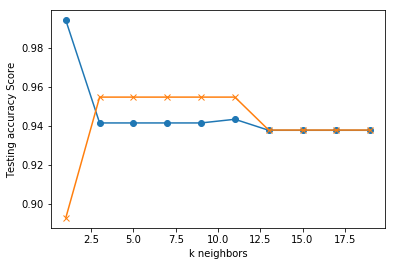

/Users/Ronessa/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Ronessa/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


k=7 Test Acc: 0.955
k=17 Test Acc: 0.938
['bad' 'bad' 'bad' ..., 'bad' 'bad' 'bad']


/Users/Ronessa/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Series([], Name: Style, dtype: object)

In [12]:
X = beer[["Flavor","Hoppiness","Maltiness","Fruitiness","Body", "pDev",
          "Sweetness","Sour","spicy","bitter", 'Aroma_None', 'Aroma_caramel',
       'Aroma_floral', 'Aroma_fruit', 'Custom Flavor_None',
       'Custom Flavor_banana', 'Custom Flavor_brown sugar',
       'Custom Flavor_burnt', 'Custom Flavor_caramel',
       'Custom Flavor_chocolate', 'Custom Flavor_earthy',
       'Custom Flavor_herbal', 'Custom Flavor_pumpkin',
       'Custom Flavor_roasted', 'Custom Flavor_smoke', 'Custom Flavor_toasted',
       'Custom Flavor_wheat', 'Color_amber', 'Color_black', 'Color_dark ',
       'Color_gold', 'Color_pale' ]]
y = beer["goodtest"].values.reshape(-1, 1)
print(X.shape, y.shape)


## K Nearest Neighbors

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

# we need a function here to determine best k value

# Note that k: 9 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print('k=7 Test Acc: %.3f' % knn.score(X_test, y_test))

# Note that k: 9 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
print('k=17 Test Acc: %.3f' % knn.score(X_test, y_test))

# not reading from csv
# recommend_list = pd.read_csv(member + 'recs.csv', encoding = "ISO-8859-1")

# paul recommends changing this to > 3.5
recommend_list = recommend_list[recommend_list["Score"] > 4]

new_beer_data = recommend_list[["Flavor","Hoppiness","Maltiness","Fruitiness","Body", "pDev",
          "Sweetness","Sour","spicy","bitter",'Aroma_None', 'Aroma_caramel', 
       'Aroma_floral', 'Aroma_fruit', 'Custom Flavor_None',
       'Custom Flavor_banana', 'Custom Flavor_brown sugar',
       'Custom Flavor_burnt', 'Custom Flavor_caramel',
       'Custom Flavor_chocolate', 'Custom Flavor_earthy',
       'Custom Flavor_herbal', 'Custom Flavor_pumpkin',
       'Custom Flavor_roasted', 'Custom Flavor_smoke', 'Custom Flavor_toasted',
       'Custom Flavor_wheat', 'Color_amber', 'Color_black', 'Color_dark ',
       'Color_gold', 'Color_pale']]
predicted_class = knn.predict(new_beer_data)
print(predicted_class)

# for item in predicted_class:
#     print(item)

recommend_list["recommended"] = predicted_class

# need to check this - if no results, need to change goodBad and rerun
recommend_list[recommend_list["recommended"] =="good"]["Style"]

df = recommend_list[recommend_list["recommended"] == "good"].sort_values("Score", ascending=False).groupby("Style").head(2)

recommend_list[recommend_list["recommended"] == "good"]

df["Style"]

In [11]:
X.dtypes

ABV                          float64
Flavor                         int64
Hoppiness                      int64
Maltiness                      int64
Fruitiness                     int64
Body                           int64
pDev                         float64
Sweetness                      int64
Sour                           int64
spicy                          int64
bitter                         int64
Aroma_None                     int64
Aroma_caramel                  int64
Aroma_floral                   int64
Aroma_fruit                    int64
Custom Flavor_None             int64
Custom Flavor_banana           int64
Custom Flavor_brown sugar      int64
Custom Flavor_burnt            int64
Custom Flavor_caramel          int64
Custom Flavor_chocolate        int64
Custom Flavor_earthy           int64
Custom Flavor_herbal           int64
Custom Flavor_pumpkin          int64
Custom Flavor_roasted          int64
Custom Flavor_smoke            int64
Custom Flavor_toasted          int64
C

In [ ]:
# if there are no recommendations
# pull in the file and create a new df without good column that we will create here
user_sort = pd.read_csv(member + "sortmatch.csv", encoding = "ISO-8859-1")
#get the rating score at the 10 percent mark
tenPercentCount = int(len(user_sort) * .10)
tenPercentRating = user_sort['user_rating'].iloc[tenPercentCount-1] #
user_sort['good'] = np.where(user_sort['user_rating']>=tenPercentRating, 'good','bad')
user_sort.to_csv(member+'sortmatch2.csv', index = False)
#then we would run through KNN again